# Doc2vec embedding

- Extract features using Doc2vec
- Evaluate features using XGBoost

## Data loading & exploration

In [1]:
# Import data
import pandas as pd

ori_papers = pd.read_csv('./data/compdata_cit_authmet.csv', index_col=False)

In [2]:
ori_papers['title'] = ori_papers['title'].fillna('NULL')

In [3]:
paper_count_by_title = ori_papers.groupby(['title'],as_index=False).size().sort_values(by='size', ascending=False)
paper_count_by_title.to_csv('../covid-review-old/data/paper_count_by_title.csv')
paper_count_by_title

,title,size
3668,NULL,31
3104,Is it safe to lift COVID-19 travel bans? The N...,3
2520,Genome sequencing of the first SARS-CoV-2 repo...,2
4088,Predicting the second wave of COVID-19 in Wash...,2
3718,Neutralizing antibody and soluble ACE2 inhibit...,2
...,...,...
1898,"Development, evaluation, and validation of mac...",1
1897,Development of severe acute respiratory syndro...,1
1896,Development of mass spectrometry-based targete...,1
1895,Development of a volumetric pancreas segmentat...,1


In [4]:
papers = ori_papers.drop_duplicates(subset=['title'])

In [5]:
papers.columns

Index(['Unnamed: 0', 'title', 'abstract', 'journal', 'DOI', 'date',
       'collection', 'published', 'nauthors', 'topic.Healthcare',
       'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics',
       'topic.Chest X-Ray', 'topic.Genomics', 'topic', 'numcit', 'influcit',
       'DL_Pdf', 'DL_Full', 'DL_Abstract', 'cit', 'cit_velocity',
       'influential_cit', 'sum.npapers', 'sum.infCit', 'mean.npapers',
       'mean.infCit', 'max.npapers', 'max.infCit'],
      dtype='object')

In [6]:
papers.drop(['Unnamed: 0'], axis=1, inplace=True)

/Users/xuxiaopeng/opt/anaconda3/envs/ml-env/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
dup_num = len(ori_papers) - len(papers)
dup_num

72

## Preprocessing

In [8]:
import re

doc_words = papers['abstract'].map(lambda x: re.sub('[,\:\.!?]', ' ', x)) #use only abstracts

In [9]:
# Tokenize &# Lemmatize the documents.
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
doc_tokenizers = doc_words.apply(lambda x : tokenizer.tokenize(x.lower()))

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in doc_tokenizers]

In [10]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [11]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [12]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [13]:
# dictionary.filter_tokens(bad_ids=[dictionary.token2id['sar']])
# dictionary.filter_tokens(bad_ids=[dictionary.token2id['coronavirus']])

In [14]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4412
Number of documents: 5686


## Doc2Vec feature extraction

In [15]:
import gensim

def pre_process(docs):
    for i in range(len(docs)):
        yield gensim.models.doc2vec.TaggedDocument(docs[i], [i])
        
train_corpus = list(pre_process(docs))

In [16]:
vector_size=50
min_count=2
epochs=40

model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)
model.build_vocab(train_corpus)

In [17]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

doc2vec_features = list(map(lambda doc:model.infer_vector(doc), docs))
pd_doc2vec_features = pd.DataFrame(doc2vec_features)

## Combine features and save

In [18]:
papers.reset_index(drop=True, inplace=True)
X = pd.concat([papers, pd_doc2vec_features], axis=1)

In [19]:
len(X)

5686

In [20]:
# collection
# pubmed        3058
# medrxiv       1247
# arxiv          758
# biorxiv        623

X['pubmed'] = papers.collection=='pubmed'
X['medrxiv'] = papers.collection=='medrxiv'
X['arxiv'] = papers.collection=='arxiv'
X['biorxiv'] = papers.collection=='biorxiv'

In [21]:
X.columns

Index([               'title',             'abstract',              'journal',
                        'DOI',                 'date',           'collection',
                  'published',             'nauthors',     'topic.Healthcare',
       'topic.Drug discovery',   'topic.Epidemiology',        'topic.Clinics',
          'topic.Chest X-Ray',       'topic.Genomics',                'topic',
                     'numcit',             'influcit',               'DL_Pdf',
                    'DL_Full',          'DL_Abstract',                  'cit',
               'cit_velocity',      'influential_cit',          'sum.npapers',
                 'sum.infCit',         'mean.npapers',          'mean.infCit',
                'max.npapers',           'max.infCit',                      0,
                            1,                      2,                      3,
                            4,                      5,                      6,
                            7,                      

In [22]:
y = pd.merge(pd.notnull(papers.published), papers.collection=='pubmed', left_index=True, right_index=True).any(axis=1)
y.value_counts()

True     3329
False    2357
dtype: int64

In [23]:
X.to_csv('./data/lda_doc2vec_feats.csv')
y.to_csv('./data/lda_doc2vec_targs.csv')

# Machine Learning

In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [29]:
lda_feats = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 
                'topic.Clinics', 'topic.Chest X-Ray', 'topic.Genomics']

doc2vec_feats = [0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8,
                       9,                10,                11,
                      12,                13,                14,
                      15,                16,                17,
                      18,                19,                20,
                      21,                22,                23,
                      24,                25,                26,
                      27,                28,                29,
                      30,                31,                32,
                      33,                34,                35,
                      36,                37,                38,
                      39,                40,                41,
                      42,                43,                44,
                      45,                46,                47,
                      48,                49]

cit_authmet_feats = ['cit',    'cit_velocity', 'influential_cit',
           'sum.npapers',      'sum.infCit',    'mean.npapers',
           'mean.infCit',     'max.npapers',      'max.infCit']

In [26]:
from sklearn.metrics import roc_curve, auc

def XGBoost_Modeling(features):
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

    xg_reg.fit(X_train[features],y_train)

    preds = xg_reg.predict(X_test[features])
    fpr_xgboost, tpr_xgboost, _ = roc_curve(y_test, preds)
    
    print("AUC is :" + str(auc(fpr_xgboost, tpr_xgboost)))
    return fpr_xgboost, tpr_xgboost

In [31]:
fpr_lda, tpr_lda = XGBoost_Modeling(lda_feats)
fpr_doc2vec, tpr_doc2vec = XGBoost_Modeling(doc2vec_feats)
fpr_lda_doc2vec, tpr_lda_doc2vec = XGBoost_Modeling(lda_feats + doc2vec_feats)
fpr_lda_doc2vec_cit_authmet, tpr_lda_doc2vec_cit_authmet = XGBoost_Modeling(lda_feats + doc2vec_feats + cit_authmet_feats)

[15:42:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7328548644338118
[15:42:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7504485645933014
[15:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7713831867057673
[15:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7818143231980244


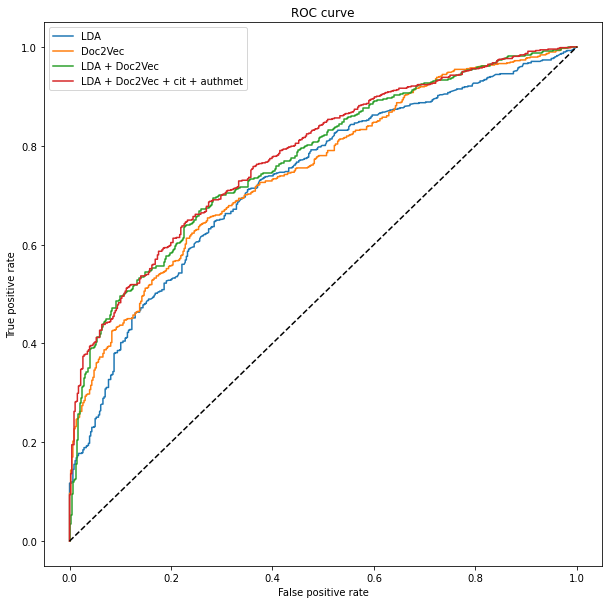

<Figure size 720x720 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(fpr_lda, tpr_lda, label='LDA')
plt.plot(fpr_doc2vec, tpr_doc2vec, label='Doc2Vec')
plt.plot(fpr_lda_doc2vec, tpr_lda_doc2vec, label='LDA + Doc2Vec')
plt.plot(fpr_lda_doc2vec_cit_authmet, tpr_lda_doc2vec_cit_authmet, label='LDA + Doc2Vec + cit + authmet')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig1 = plt.gcf()
plt.plot([0, 1], [0, 1], 'k--')
plt.show()
plt.draw()
#fig1.savefig('new_data_roc.png', dpi=100)

## Feature importance

[15:42:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<Figure size 720x720 with 0 Axes>

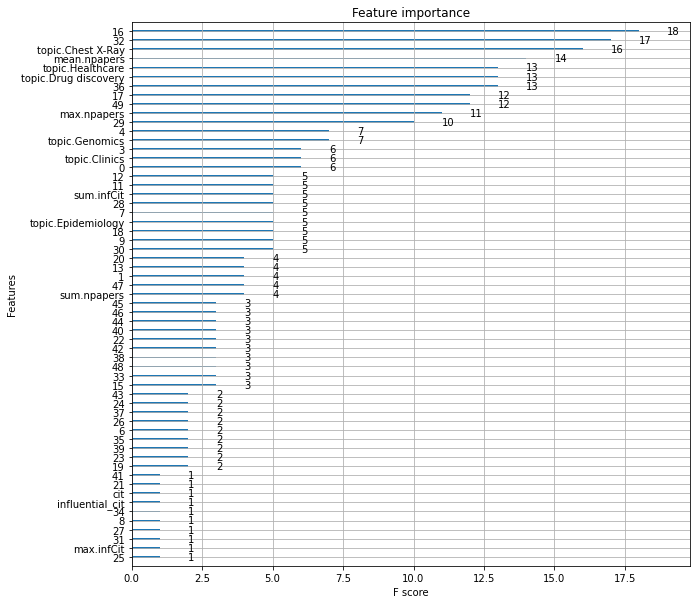

<Figure size 720x720 with 0 Axes>

In [34]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X[lda_feats + doc2vec_feats + cit_authmet_feats],y)

plt.figure()
xgb.plot_importance(xg_reg)
fig2 = plt.gcf()
plt.show()
plt.draw()
#fig2.savefig('new_data_feature_importance.png', dpi=100)